In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gru_ode_bayes 
import gru_ode_bayes.data_utils as data_utils
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from gru_ode_bayes import Logger
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components

In [2]:
file_path="E:\\Data\\Private\\MIMIC_III\\mimic_csv\\Clean_data\\"
csv_file_path =file_path+"GRU_ODE_Dataset.csv"
covs_file_path=file_path+"GRU_ODE_covariates.csv"
tags_file_path=file_path+"GRU_ODE_death_tags.csv"

In [3]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# ロード
d=pickle_load( file_path+'sample_unique_id_dict.pickle')


In [5]:
idx=np.array(list(d.keys()))

In [6]:
dir_path=r"E:/Data/Private/MIMIC_III/mimic_csv/Clean_data/"
test_idx = np.load(dir_path+r"fold_idx_0/test_idx.npy")

## covariateの対応表を作成
(np.argmaxでcovをカテゴリ化する際に、コードがずれるのを防ぐため)

In [7]:
cov_df=pd.read_csv(covs_file_path)

In [8]:
np.argmax(cov_df.iloc[:,1:].to_numpy(), axis=1)

array([ 10, 305, 266, ..., 220, 253, 436], dtype=int64)

In [9]:
cov_list=list(cov_df.columns)
cov_list.pop(0)

'ID'

In [10]:
cov_dict={}
for i,cov in enumerate(cov_list):
    cov_dict[i]=cov

In [ ]:
# このdictでargmax->ICD9Code化する
cov_dict

In [7]:
# data_train = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path, cov_file=covs_file_path, idx=idx)

In [12]:
# testdataを使う場合
data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
                                    cov_file= covs_file_path, idx=test_idx, validation = False,
                                    val_options =None)

In [695]:
# 全データを使う場合
data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
                                    cov_file= covs_file_path, idx=None, validation = False,
                                    val_options =None)

In [13]:
dl   = DataLoader(dataset=data_test, collate_fn=data_utils.custom_collate_fn, shuffle=True, batch_size=100,num_workers=4)

In [14]:
#Model parameters.
params_dict=dict()
params_dict["hidden_size"] = 100
params_dict["p_hidden"] = 25
params_dict["prep_hidden"] = 10
params_dict["logvar"] = True
params_dict["mixing"] = 1e-4 #Weighting between KL loss and MSE loss.
params_dict["delta_t"]=0.1
params_dict["T"]= 100  #100
# lambda>0のときClassificationを行う
params_dict["lambda"] = 1 #Weighting between classification and MSE loss.
# lambda==0でないとき、validationオプションはなしにされている(validation==False)
# validationがないときは、summaryのcorrelation,validation_mse,loglik_lossは計算されず0で記録される

params_dict["classification_hidden"] = 2
params_dict["cov_hidden"] = 50
params_dict["weight_decay"] = 0.0001
params_dict["dropout_rate"] = 0
params_dict["lr"]=0.001
params_dict["full_gru_ode"] = True
params_dict["no_cov"] = False # covファイルが存在するときFalse
params_dict["impute"] = False


params_dict["input_size"]=data_test.variable_num
params_dict["cov_size"] = data_test.cov_dim

In [15]:
# model instance 生成
device = torch.device("cuda")
model = gru_ode_bayes.NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                            p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"],
                                            logvar = params_dict["logvar"], mixing = params_dict["mixing"],
                                            classification_hidden=params_dict["classification_hidden"],
                                            cov_size = params_dict["cov_size"], cov_hidden = params_dict["cov_hidden"],
                                            dropout_rate = params_dict["dropout_rate"],full_gru_ode= params_dict["full_gru_ode"], impute = params_dict["impute"])
model.to(device)

NNFOwithBayesianJumps(
  (p_model): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=25, out_features=192, bias=True)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=2, out_features=1, bias=True)
  )
  (gru_c): FullGRUODECell_Autonomous(
    (lin_hh): Linear(in_features=100, out_features=100, bias=False)
    (lin_hz): Linear(in_features=100, out_features=100, bias=False)
    (lin_hr): Linear(in_features=100, out_features=100, bias=False)
  )
  (gru_obs): GRUObservationCellLogvar(
    (gru_d): GRUCell(960, 100)
    (gru_debug): GRUCell(960, 100)
  )
  (covariates_map): Sequential(
    (0): Linear(in_features=530, out_features=50, bias=True)

In [16]:
# model parameter load
model_path = r'E:\Data\Private\MIMIC_III\mimic_csv\Clean_data\trained_models\MIMIC_2_bins_20201110_122631_MAX.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [17]:
# onehot->categorical化 のテスト
np.argmax(cov.cpu().numpy(), axis=1)

AttributeError: 'str' object has no attribute 'cpu'

In [18]:
b["y"].numpy().squeeze()

NameError: name 'b' is not defined

In [17]:
cov_latent_dict=dict()
for i, b in tqdm(enumerate(dl),total=len(dl)):
    times    = b["times"]
    time_ptr = b["time_ptr"]
    X        = b["X"].to(device)
    M        = b["M"].to(device)
    obs_idx  = b["obs_idx"]
    cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
    cov_np   = np.array([cov_dict[i] for i in cov_np])
    cov      = b["cov"].to(device)
    labels   = b["y"].to(device)
    batch_size = labels.size(0)
    if b["X_val"] is not None:
        X_val     = b["X_val"].to(device)
        M_val     = b["M_val"].to(device)
        times_val = b["times_val"]
        times_idx = b["index_val"]
    h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
    hT, loss, class_pred, t_vec, p_vec, h_vec, _, _,_,_  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)
    cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"y":b["y"].numpy().squeeze()}

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:30<00:00,  1.40s/it]


In [21]:
def return_latent(model,x):
    for i,layer in enumerate(model.classification_model()):
        x=layer(x)
        if i==3:
            return x

In [22]:
return_latent(model,hT)

TypeError: forward() missing 1 required positional argument: 'input'

In [807]:
# 1回だけまわす用
# cov_latent_dict=dict()
# for i, b in tqdm(enumerate(dl),total=len(dl)):
times    = b["times"]
time_ptr = b["time_ptr"]
X        = b["X"].to(device)
M        = b["M"].to(device)
obs_idx  = b["obs_idx"]
cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
cov      = b["cov"].to(device)
labels   = b["y"].to(device)
batch_size = labels.size(0)
if b["X_val"] is not None:
    X_val     = b["X_val"].to(device)
    M_val     = b["M_val"].to(device)
    times_val = b["times_val"]
    times_idx = b["index_val"]
h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
hT, loss, class_pred, t_vec, p_vec, h_vec, _, _  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)
# cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"y":b["y"].numpy().squeeze()}

In [737]:
h=h_vec.cpu().detach().numpy()
p=p_vec.cpu().detach().numpy()

In [518]:
p.shape

(1097, 24, 192)

In [519]:
b["times"][-1]

96.0

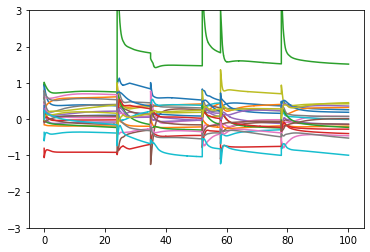

In [738]:
%matplotlib inline
plt.plot(t_vec,p[:,0,0:20])
plt.ylim(-3,3)
plt.show()

In [521]:
t_vec[-1]

100.09999999999859

In [46]:
h.shape　　# (time , sample , variables) variablesは潜在変数のものなので具体的な意味はない

(1099, 100, 100)

In [67]:
h[0,:,:].shape

(100, 100)

In [ ]:
import pprint
pprint.pprint(cov_latent_dict)

In [701]:
pickle_dump(cov_latent_dict,file_path+"cov_latent_dict.pickle")

# 潜在変数を用いた分析

In [702]:
cov_latent_dict=pickle_load(file_path+"cov_latent_dict.pickle")

In [703]:
h0=cov_latent_dict[0]['h0']
hT=cov_latent_dict[0]['hT']
cov=cov_latent_dict[0]['cov']
y=cov_latent_dict[0]['y']
for i in range(list(cov_latent_dict.keys())[-1]):
    h0=np.vstack([h0,cov_latent_dict[i+1]['h0']])
    hT=np.vstack([hT,cov_latent_dict[i+1]['hT']])
    cov=np.append(cov,cov_latent_dict[i+1]['cov'])
    y=np.append(y,cov_latent_dict[i+1]['y'])

In [704]:
h0_to_df=pd.DataFrame(h0)

In [705]:
h0_df=pd.DataFrame([cov,y]).T
h0_df.columns=["cov","y"]
h0_df["y"]=h0_df["y"].astype("float")
h0_df_comp=pd.concat([h0_df,h0_to_df],axis=1)
h0_df_agg=h0_df_comp.groupby("cov").mean()
h0_df_agg=h0_df_agg.reset_index()
# h0_df_comp[h0_df_comp["cov"]=="215"].head()

In [706]:
h0_df_agg.head()
# print(len(h0_df_agg))

,cov,y,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,004,0.000000,-0.062085,0.156295,0.178428,0.229884,0.079358,0.051933,0.069981,-0.108084,...,0.220373,-0.310343,-0.518292,-0.280724,0.137229,-0.325405,-0.029420,0.063721,-0.108522,-0.110085
1,008,0.098039,-0.263271,0.130559,0.265037,0.413098,0.213538,0.147816,0.088929,-0.262424,...,0.451152,-0.430565,-0.718901,-0.434737,0.167480,-0.385039,-0.173651,0.203165,-0.060991,-0.354450
2,009,0.000000,-0.185246,0.379319,0.147456,0.170265,0.249295,0.428950,0.157747,-0.209614,...,0.270183,-0.337346,-0.731601,-0.345363,0.343483,-0.418393,0.027567,0.485171,-0.198887,-0.253867
3,011,0.000000,-0.238409,-0.045251,-0.118851,0.407269,0.014349,-0.217831,0.175410,-0.297209,...,0.211766,-0.496595,-0.802523,-0.410702,0.161735,-0.682995,-0.201155,0.053797,-0.205931,-0.502542
4,012,0.000000,-0.172578,0.498945,0.111167,0.278824,-0.027864,0.252500,0.305121,-0.291861,...,0.291386,-0.619217,-0.808321,-0.511654,0.046338,-0.546425,0.051499,0.286829,-0.358200,-0.367675


In [763]:
# h0を集計後のものに修正
h0=h0_df_agg.iloc[: ,2:].values

In [765]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
h0=scaler.fit_transform(h0)
hT=scaler.fit_transform(hT)

In [119]:
# from sklearn.decomposition import PCA
# pca     = PCA(n_components=2)
# h0_2dim = pca.fit_transform(h0)
# hT_2dim = pca.fit_transform(hT)

In [332]:
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

In [ ]:
# from sklearn.manifold import TSNE
# tsne=TSNE(n_components=2, random_state=1)
# h0_2dim=tsne.fit_transform(h0)
# hT_2dim=tsne.fit_transform(hT)

In [766]:
# umapのほうがかなり高速なのでtsne->umap
import umap
umap_obj=umap.UMAP()
h0_2dim=umap_obj.fit_transform(h0)
hT_2dim=umap_obj.fit_transform(hT)

## 病種での死亡率

In [767]:
h0_2dim_df=pd.DataFrame(h0_2dim)
len(h0_2dim_df)

530

In [768]:
h0_df_agg.iloc[: ,0]

0      004
1      008
2      009
3      011
4      012
      ... 
525    V55
526    V56
527    V58
528    V59
529    V71
Name: cov, Length: 530, dtype: object

In [769]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,004,0.000000,24.403437,-11.847872
1,008,0.098039,22.970318,-2.646829
2,009,0.000000,24.850464,0.171323
3,011,0.000000,23.872335,-0.591278
4,012,0.000000,24.587210,0.669420
...,...,...,...,...
525,V55,0.000000,23.099054,0.943979
526,V56,0.500000,23.875248,-7.653425
527,V58,0.190476,23.039660,-4.114607
528,V59,0.000000,25.709982,0.796146


In [795]:
h0_mean.iloc[:,2:4]

,h0_x,h0_y
0,24.403437,-11.847872
1,22.970318,-2.646829
2,24.850464,0.171323
3,23.872335,-0.591278
4,24.587210,0.669420
...,...,...
525,23.099054,0.943979
526,23.875248,-7.653425
527,23.039660,-4.114607
528,25.709982,0.796146


In [564]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,004,0.000000,-7.038946,0.952551
1,008,0.250000,-6.873696,-4.604794
2,009,0.000000,-5.358940,6.951535
3,013,0.000000,10.105502,6.546349
4,027,0.000000,-7.326498,0.920395
...,...,...,...,...
277,998,0.083333,-10.062037,1.926910
278,999,0.000000,-7.158367,-7.373271
279,V58,0.000000,-9.698045,3.471290
280,V59,0.000000,-1.569052,6.389301


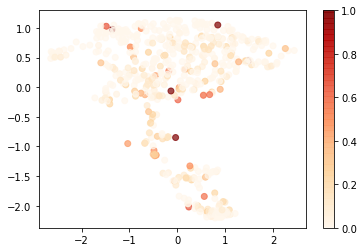

In [797]:
h0_mean.iloc[:,2:4]=scaler.fit_transform(h0_mean.iloc[:,2:4])
plt.scatter(h0_mean["h0_x"],h0_mean["h0_y"],c=h0_mean["y"],cmap='OrRd',alpha=0.7)
plt.colorbar()

## hTでの病種別重心と死亡率

In [771]:
df=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T

In [772]:
df.columns=["cov","y","hT_x","hT_y"]

In [773]:
df.head()

,cov,y,hT_x,hT_y
0,441,1,4.887,10.0086
1,562,0,10.1137,9.10739
2,530,0,3.48018,8.22019
3,038,1,9.91223,4.10534
4,998,0,11.1957,9.43596


In [774]:
df["y"]=df["y"].astype(float)
df["hT_x"]=df["hT_x"].astype(float)
df["hT_y"]=df["hT_y"].astype(float)
hT_stat=df.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

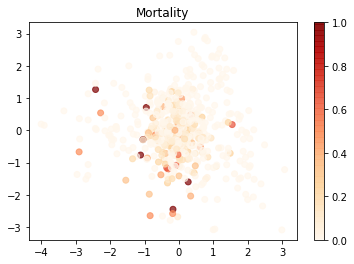

In [803]:
hT_stat.iloc[:,1:3]=scaler.fit_transform(hT_stat.iloc[:,1:3])
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='OrRd',alpha=0.7)
plt.colorbar()
plt.title("Mortality")

## hTでの全点表示(一応)

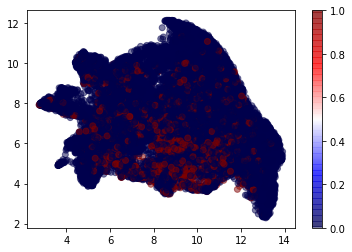

In [777]:
plt.scatter(hT_2dim[:,0],hT_2dim[:,1],c=y,cmap='seismic',alpha=0.5)
plt.colorbar()

## 病種を大分類に

In [778]:
# ICD9をshortcodeからさらに大分類に分ける a-rまで
def classifyICD(code):
    if code.isdecimal():
        code=int(code)
        if code <=139:
            return "a" #infectious and parasitic diseases
        elif code<=239:
            return "b" #neoplasms
        elif code<=279:
            return "c" #endocrine, nutritional and metabolic diseases, and immunity disorders
        elif code<=289:
            return "d" #Diseases of the Blood and Blood-forming Organs
        elif code<=319:
            return  "e"#Mental Disorders
        elif code<= 359:
            return "f"# diseases of the nervous system
        elif code<= 389:
            return  "g"#sense organs
        elif code<= 459:
            return "h"# Diseases of the Circulatory System
        elif code<= 519 :
            return  "i"# Diseases of the Respiratory System
        elif code<= 579:
            return "j"# Diseases of the Digestive System
        elif code<= 629:
            return "k"# Diseases of the Genitourinary System
        elif code<= 679:
            return  "l"# Complications of Pregnancy, Childbirth, and the Puerperium
        elif code<= 709:
            return "m"#Diseases of the Skin and Subcutaneous Tissue
        elif code<= 739:
            return  "n"# Diseases of the Musculoskeletal System and Connective Tissue
        elif code<= 759:
            return  "o"# Congenital Anomalies
        elif code<= 779:
            return  "p"#Certain Conditions originating in the Perinatal Period
        elif code<= 799:
            return  "q"#Symptoms, Signs and Ill-defined Conditions
        elif code<= 999:
            return  "r"#Injury and Poisoning
    else:
        return "others"

In [779]:
classify=[classifyICD(code) for code in cov]
classify[0:10]

['h', 'j', 'j', 'a', 'r', 'h', 'h', 'h', 'h', 'h']

In [780]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,004,0.000000,24.403437,-11.847872
1,008,0.098039,22.970318,-2.646829
2,009,0.000000,24.850464,0.171323
3,011,0.000000,23.872335,-0.591278
4,012,0.000000,24.587210,0.669420
...,...,...,...,...
525,V55,0.000000,23.099054,0.943979
526,V56,0.500000,23.875248,-7.653425
527,V58,0.190476,23.039660,-4.114607
528,V59,0.000000,25.709982,0.796146


In [781]:
h0_mean["category"]=h0_mean["cov"].map(classifyICD)

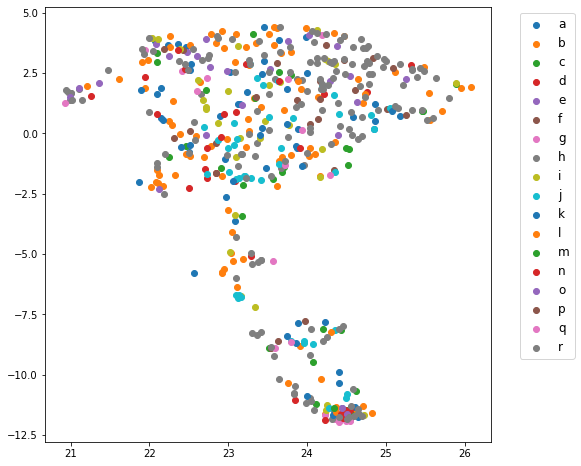

In [782]:
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(h0_mean[h0_mean["category"]==char]["h0_x"],h0_mean[h0_mean["category"]==char]["h0_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

In [783]:
df=pd.DataFrame([classify,y,h0_2dim[:,0],h0_2dim[:,1]]).T
df.columns=["class","label","h0_x","h0_y"]
# df["cov"]=df["cov"].astype('int')

In [784]:
df["class"]=df["class"].astype(str)
df.head()

,class,label,h0_x,h0_y
0,h,1,24.4034,-11.8479
1,j,0,22.9703,-2.64683
2,j,0,24.8505,0.171323
3,a,1,23.8723,-0.591278
4,r,0,24.5872,0.66942


## UMAP

In [785]:
import umap
umap_obj=umap.UMAP()
h0_2dim=umap_obj.fit_transform(h0)
hT_2dim=umap_obj.fit_transform(hT)

## 病種での死亡率(h0)

In [786]:
h0_2dim_df=pd.DataFrame(h0_2dim)
len(h0_2dim_df)

530

In [787]:
h0_df_agg.iloc[: ,0]

0      004
1      008
2      009
3      011
4      012
      ... 
525    V55
526    V56
527    V58
528    V59
529    V71
Name: cov, Length: 530, dtype: object

In [461]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,0,0.000000,11.815024,-16.102049
1,1,0.250000,14.506060,-11.086783
2,2,0.000000,13.426558,-9.680126
3,5,0.000000,15.528574,-7.528638
4,7,0.000000,12.162886,-16.450167
...,...,...,...,...
277,521,0.083333,12.865460,-15.985824
278,522,0.000000,15.553524,-11.922981
279,527,0.000000,13.501745,-16.087116
280,528,0.000000,13.138739,-12.882273


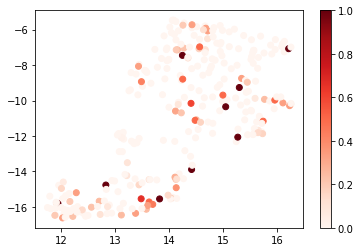

In [465]:
plt.scatter(h0_mean["h0_x"],h0_mean["h0_y"],c=h0_mean["y"],cmap='Reds')
plt.colorbar()

## hTでの病種別重心と死亡率

In [466]:
df=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T

In [467]:
df.columns=["cov","label","hT_x","hT_y"]

In [468]:
df["cov"]=df["cov"].astype('int')

In [469]:
hT_stat=df.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

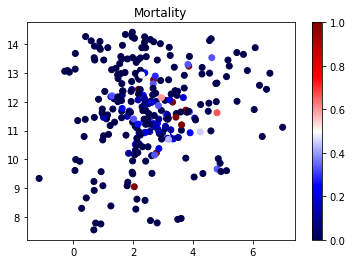

In [470]:
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["label"],cmap='seismic')
plt.colorbar()
plt.title("Mortality")

Text(0.5, 1.0, 'cov')

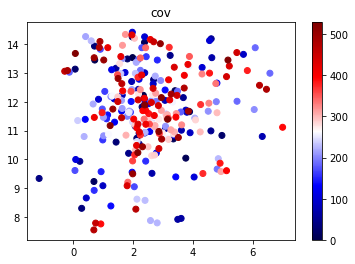

In [471]:
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=list(hT_stat.index),cmap='seismic')
plt.colorbar()
plt.title("cov")

In [691]:
def draw_umap(data,label ,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=(8,8))
    cmap="cool"
    if n_components == 1:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], range(len(u)), c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 2:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], u[:,1],c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=label, s=100,cmap=cmap)


    plt.title(title, fontsize=18)

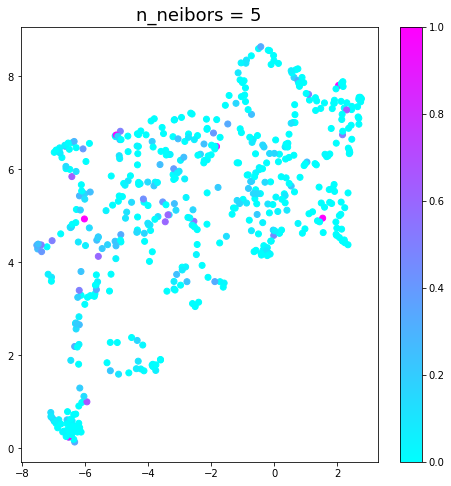

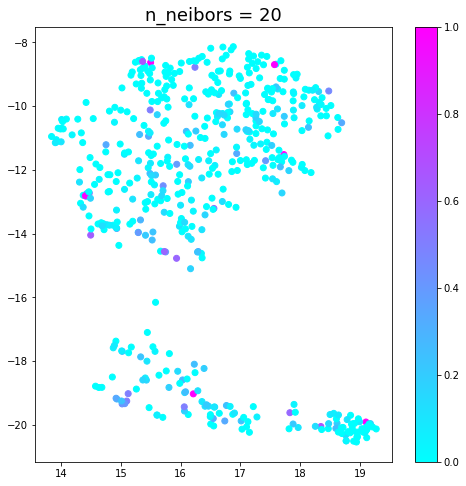

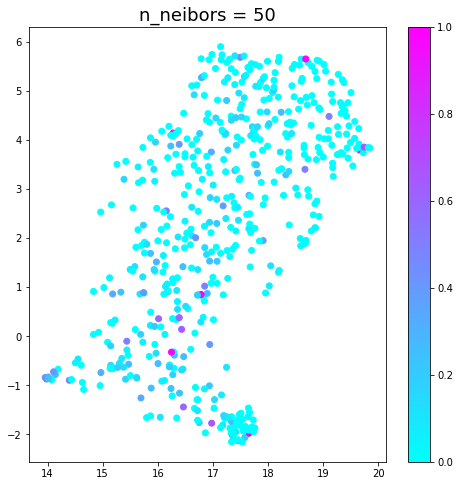

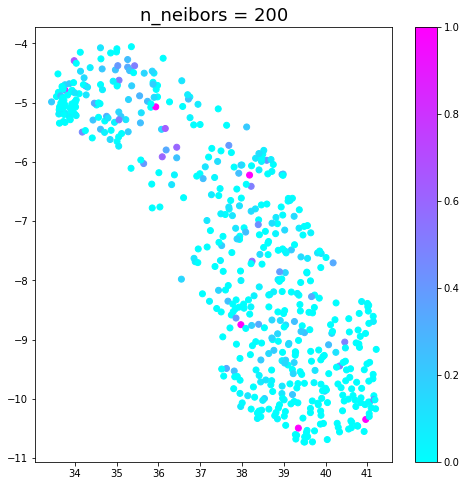

In [788]:
for n in ( 5,  20, 50,  200):
    draw_umap(h0,h0_mean["y"],n_neighbors=n ,title=f"n_neibors = {n}")

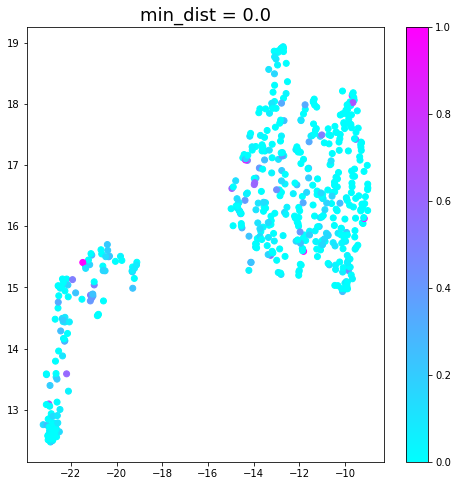

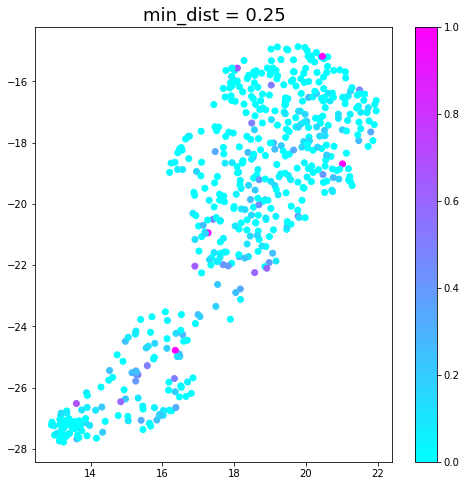

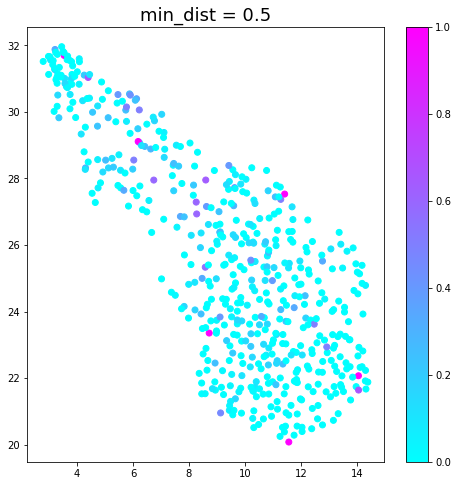

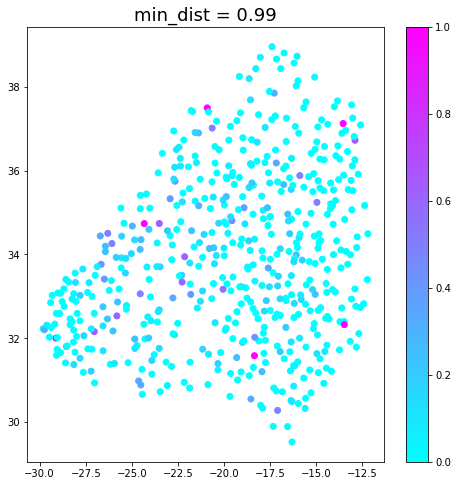

In [789]:
for d in (0.0,  0.25, 0.5, 0.99):
    draw_umap(h0,h0_mean["y"], min_dist=d , title='min_dist = {}'.format(d))

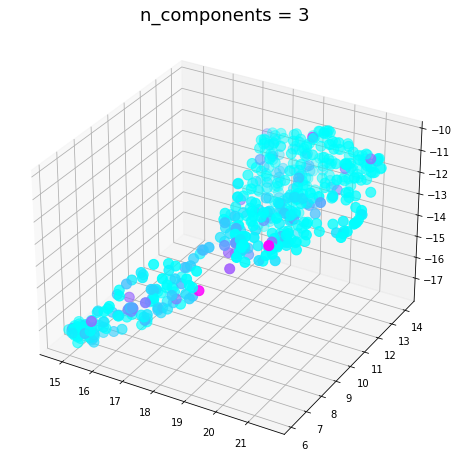

In [790]:
draw_umap(h0,h0_mean["y"],min_dist=0.2,n_components=3, title='n_components = 3')